# HR-FOSI Quick BSF Computation

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
import copy
import matplotlib.pyplot as plt
#from geocat.viz import util as gvutil
import util
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Create Dask Cluster

In [51]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [3]:
# Use this if computing annual means:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(jobs=10) 

In [4]:
cluster

# Main Processing

In [10]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/hist/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.0276-01.nc'
ds = xr.open_dataset(fin).chunk({'nlon':400,'nlat':400})

In [21]:
ds = util.pop_add_cyclic(ds)

In [22]:
ds.UVEL

,Array,Chunk
Bytes,2.00 GiB,37.84 MiB
Shape,"(1, 62, 2400, 3601)","(1, 62, 400, 400)"
Count,295 Tasks,66 Chunks
Type,float32,numpy.ndarray


In [23]:
%%time
# get POP grid
infile='/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc'
dsg = xr.open_dataset(infile)
dsg = util.pop_add_cyclic(dsg)
htn = dsg.HTN
hte = dsg.HTE
tarea = dsg.TAREA
dzt = dsg.DZT
dzu = dsg.DZU
dxt = dsg.DXT
dyt = dsg.DYT
dxu = dsg.DXU
dyu = dsg.DYU
ht = dsg.HT
hu = dsg.HU
kmt = dsg.KMT
rmask = dsg.REGION_MASK
tlon = dsg.TLONG
tlat = dsg.TLAT

CPU times: user 6.26 s, sys: 8.94 s, total: 15.2 s
Wall time: 44.4 s


In [24]:
%%time
uvel = ds.UVEL / 100.
uvel['z_t'] = dzt['z_t']
vvel = ds.VVEL / 100.
vvel['z_t'] = dzt['z_t']

CPU times: user 3.24 ms, sys: 34 µs, total: 3.27 ms
Wall time: 3.28 ms


In [25]:
dzt

<xarray.DataArray 'DZT' (z_t: 62, nlat: 2400, nlon: 3601)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * z_t      (z_t) float64 5.0 15.0 25.0 35.0 ... 5.375e+03 5.625e+03 5.875e+03
Dimensions without coordinates: nlat, nlon
Attributes:
    units:    meter

In [26]:
%%time
su = (uvel*dzt*dxu).sum('z_t')
su.attrs['units']='m^3/s'
sv = (vvel*dzt*dxu).sum('z_t')
sv.attrs['units']='m^3/s'

CPU times: user 8.78 s, sys: 441 µs, total: 8.78 s
Wall time: 8.95 s


In [27]:
atlmask = (rmask==6) | (rmask==8) | (rmask==9)

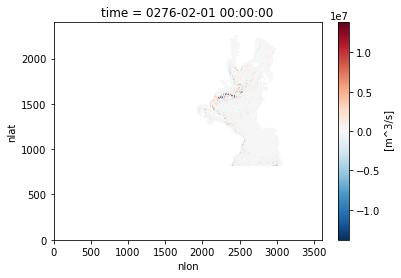

In [28]:
%%time
su_atl = su.where(atlmask)
sv_atl = sv.where(atlmask)
sv_atl.plot()

In [40]:
bsf = sv_atl.cumsum('nlon')/1.e6

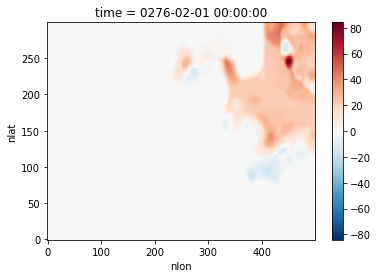

In [31]:
bsf.sel(nlon=slice(1700,2200),nlat=slice(1200,1500)).plot()

In [41]:
bsf = bsf.where(kmt!=0).load()

In [46]:
np.arange(0,21,1)*5. - 50

array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
         5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.])

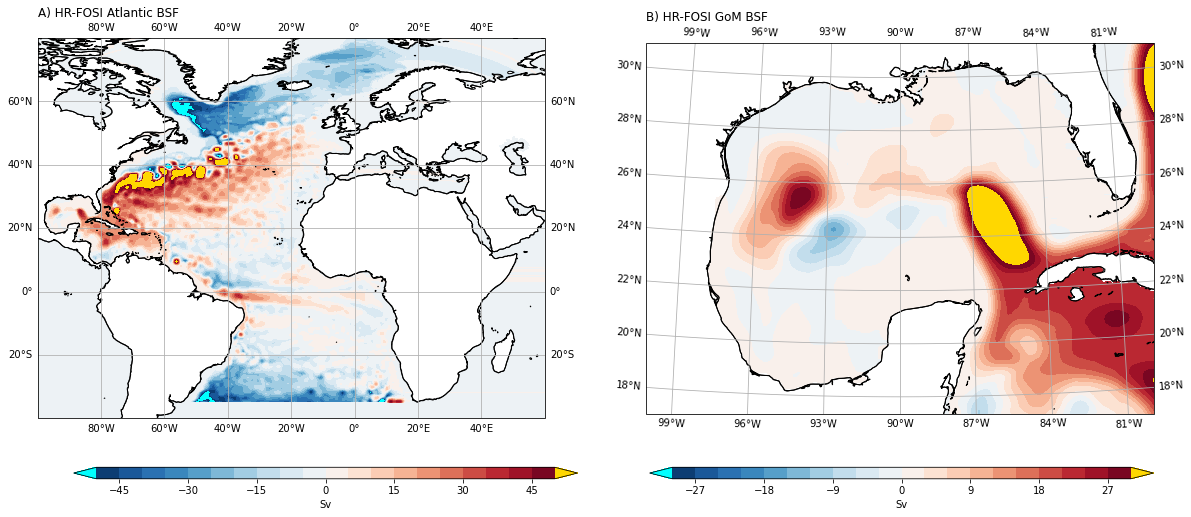

In [50]:
# MLD Mean & Std Dev
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
underclr = 'cyan'
lineclr = 'yellow'
lineclr2 = 'orange'

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1, projection=proj1)
ax2 = fig.add_subplot(1, 2, 2, projection=proj2)

mnlevs = np.arange(0,21,1)*5. - 50
cntr1 = ax1.contourf(tlon, tlat, bsf.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr1.cmap.set_over(overclr)
cntr1.cmap.set_under(underclr)
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI Atlantic BSF',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,60, -40, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

colmap = copy.copy(plt.cm.RdBu_r)
mnlevs = np.arange(0,21,1)*3. - 30
cntr2 = ax2.contourf(tlon, tlat, bsf.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr2.cmap.set_over(overclr)
cntr2.cmap.set_under(underclr)
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI GoM BSF',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='Sv')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='Sv')

### Look at how offline BSF compares to online BSF in LR

In [47]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/FOSI/LR/g210.GIAF_JRA.v14.gx1v7.02/ocn/hist/'
fin = datadir+'g210.GIAF_JRA.v14.gx1v7.02.pop.h.0243-01.nc'
ds = xr.open_dataset(fin)
ds = ds[['TLONG','TLAT','KMT','REGION_MASK','DXU','dz','VVEL','BSF']]
ds = util.pop_add_cyclic(ds)

In [48]:
%%time
vvel = ds.VVEL
vvel = vvel.where(vvel<1.e30)
vvel = vvel / 100.
dxu = ds.DXU / 100.
dz = ds.dz / 100.

CPU times: user 18 ms, sys: 894 µs, total: 18.9 ms
Wall time: 18.9 ms


In [50]:
sv = (vvel*dz*dxu).sum('z_t')
sv.attrs['units']='m^3/s'

In [51]:
rmask = ds.REGION_MASK
atlmask = (rmask==6) | (rmask==8) | (rmask==9)

In [52]:
sv_atl = sv.where(atlmask)

In [54]:
bsf = sv_atl.cumsum('nlon')/1.e6
kmt = ds.KMT
bsf = bsf.where(kmt!=0)

In [57]:
bsfonline = ds.BSF
bsfonline = bsfonline.where(kmt!=0)

In [55]:
tlon = ds.TLONG
tlat = ds.TLAT

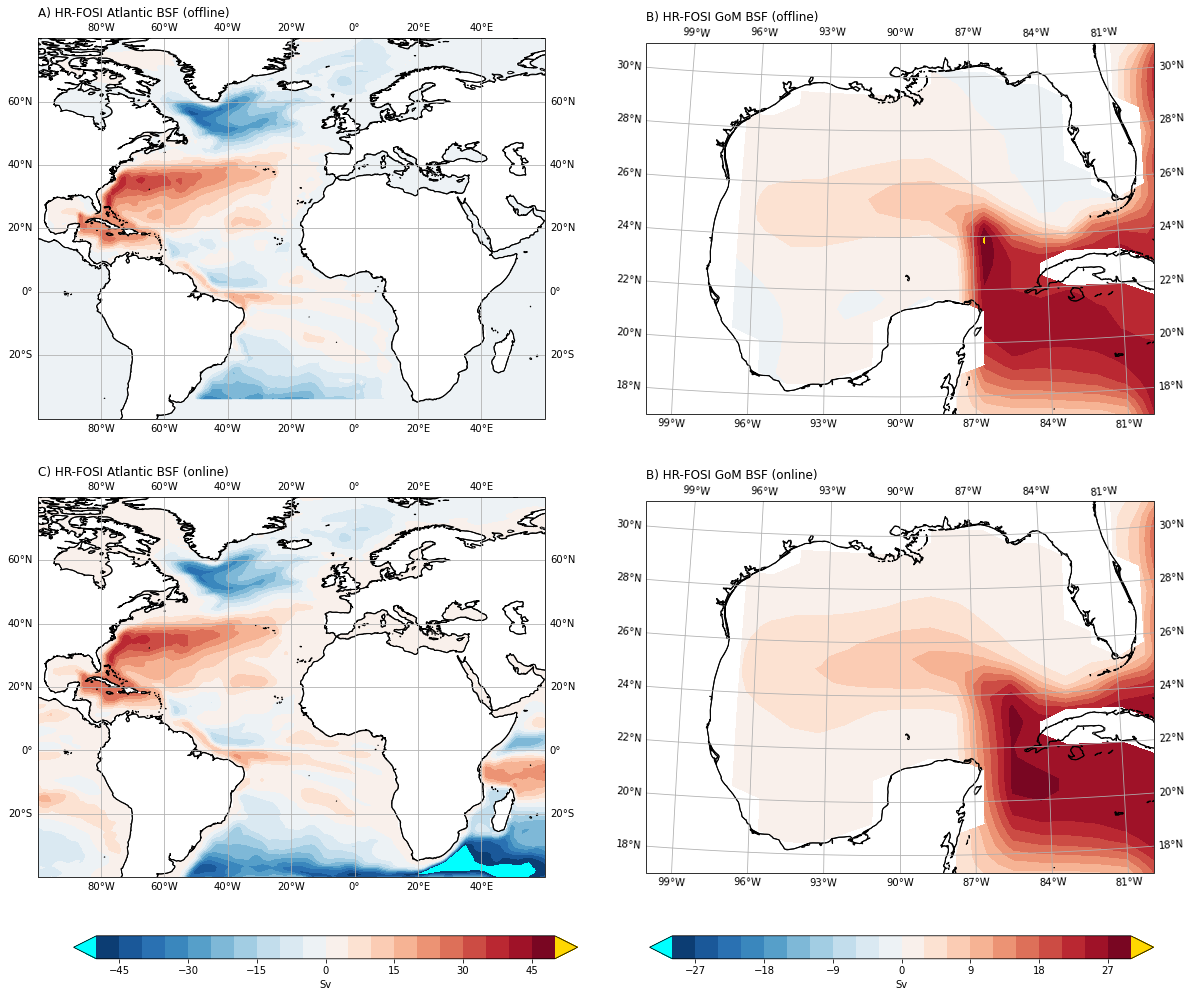

In [60]:
# MLD Mean & Std Dev
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
underclr = 'cyan'
lineclr = 'yellow'
lineclr2 = 'orange'

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 16))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj2)
ax3 = fig.add_subplot(2, 2, 3, projection=proj1)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

mnlevs = np.arange(0,21,1)*5. - 50
cntr1 = ax1.contourf(tlon, tlat, bsf.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr1.cmap.set_over(overclr)
cntr1.cmap.set_under(underclr)
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI Atlantic BSF (offline)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,60, -40, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

colmap = copy.copy(plt.cm.RdBu_r)
mnlevs = np.arange(0,21,1)*3. - 30
cntr2 = ax2.contourf(tlon, tlat, bsf.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr2.cmap.set_over(overclr)
cntr2.cmap.set_under(underclr)
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI GoM BSF (offline)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

mnlevs = np.arange(0,21,1)*5. - 50
cntr3 = ax3.contourf(tlon, tlat, bsfonline.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr3.cmap.set_over(overclr)
cntr3.cmap.set_under(underclr)
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) HR-FOSI Atlantic BSF (online)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,60, -40, 80]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

colmap = copy.copy(plt.cm.RdBu_r)
mnlevs = np.arange(0,21,1)*3. - 30
cntr4 = ax4.contourf(tlon, tlat, bsfonline.isel(time=0), levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr4.cmap.set_over(overclr)
cntr4.cmap.set_under(underclr)
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('B) HR-FOSI GoM BSF (online)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='Sv')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='Sv')